In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from model_module import model_preparation, best_model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [ ]:
df = pd.read_csv("./data/bse_eq_15min_2018_2025.csv").set_index("datetime").drop(columns=["timestamp"])
df.head()

,open,high,low,close,volume
datetime,,,,,
2018-01-01 09:30:00+05:30,101.89,103.22,101.79,103.00,330300
2018-01-01 09:45:00+05:30,103.00,103.78,102.67,103.06,306486
2018-01-01 10:00:00+05:30,103.06,103.33,102.79,103.11,182691
2018-01-01 10:15:00+05:30,103.11,103.66,102.95,103.42,125217
2018-01-01 10:30:00+05:30,103.42,103.56,103.28,103.44,58653


#### Creating Features

    Directional momentum

In [ ]:
# Trend direction
df['green_candle'] = (df['close'] > df['open']).astype(int)
df['higher_high'] = (df['high'] > df['high'].shift(1)).astype(int)
df['lower_low'] = (df['low'] < df['low'].shift(1)).astype(int)
df['close_above_sma13'] = (df['close'] > df['close'].rolling(13).mean()).astype(int)
df['close_above_sma26'] = (df['close'] > df['close'].rolling(26).mean()).astype(int)

# # Momentum direction
# df['return_1_sign'] = np.sign(df['log_return'].shift(1))
# df['return_4_positive'] = (df['return_4'] > 0).astype(int)
# df['return_13_positive'] = (df['return_13'] > 0).astype(int)

In [ ]:
# Time features (datetime is index)
df['hour'] = pd.to_datetime(df.index).hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week'] = pd.to_datetime(df.index).dayofweek

In [ ]:
df['hl_ratio'] = (df['high'] - df['low']) / df['close']
df['upper_shadow'] = (df['high'] - df[['open', 'close']].max(axis=1)) / df['close']
df['lower_shadow'] = (df[['open', 'close']].min(axis=1) - df['low']) / df['close']

    momentum Features

In [ ]:
df['return_4'] = np.log(df['close'] / df['close'].shift(4))   # 1 hour
df['return_13'] = np.log(df['close'] / df['close'].shift(13)) # ~3 hours
df['return_26'] = np.log(df['close'] / df['close'].shift(26)) # 1 day

    Volume

In [ ]:
df = df.copy()
lookback = 20  # 20 bars = 5 hours of 15min data

df["volume_ma"] = df["volume"].rolling(window=lookback).mean()
df["volume_ratio"] = df["volume"] / df["volume_ma"]

# Clean up
df = df.dropna(how="any")

    RSI

In [ ]:
# RSI calculation
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI with standard 14-period
df["rsi_14"] = calculate_rsi(df["close"], period=14)

# Clean up
df = df.dropna(how="any")

# Check the feature
print("RSI Statistics:")
print(df["rsi_14"].describe())
print(f"\nOverbought (>70): {(df['rsi_14'] > 70).sum()} bars")
print(f"Oversold (<30): {(df['rsi_14'] < 30).sum()} bars")


RSI Statistics:
count    49017.000000
mean        48.915795
std         17.923096
min          0.000000
25%         35.997910
50%         48.838752
75%         61.587708
max         99.194210
Name: rsi_14, dtype: float64

Overbought (>70): 6523 bars
Oversold (<30): 7823 bars


    MACD

In [ ]:
# MACD calculation
def calculate_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

df["macd"], df["macd_signal"], df["macd_hist"] = calculate_macd(df["close"])

# Normalize MACD features by price (make them relative)
df["macd_norm"] = df["macd"] / df["close"]
df["macd_hist_norm"] = df["macd_hist"] / df["close"]

# Clean up
df = df.dropna(how="any")

print("MACD Statistics:")
print(df[["macd_norm", "macd_hist_norm"]].describe())

MACD Statistics:
          macd_norm  macd_hist_norm
count  49017.000000    49017.000000
mean       0.000360        0.000004
std        0.006218        0.001692
min       -0.038312       -0.021902
25%       -0.002591       -0.000732
50%       -0.000141       -0.000044
75%        0.002880        0.000658
max        0.043614        0.014145


    Moving Averages

In [ ]:
# Moving averages (just for calculation, not direct features)
df["5ma"] = df["close"].rolling(5).mean()
df["10ma"] = df["close"].rolling(10).mean()
df["50ma"] = df["close"].rolling(50).mean()
df["200ma"] = df["close"].rolling(200).mean()  # Fixed: was 100

# RELATIVE features (normalized by price)
df["5_10_ma_diff_pct"] = (df["5ma"] - df["10ma"]) / df["close"]
df["close_5ma_diff_pct"] = (df["close"] - df["5ma"]) / df["close"]
df["close_10ma_diff_pct"] = (df["close"] - df["10ma"]) / df["close"]
df["golden_cross_pct"] = (df["50ma"] - df["200ma"]) / df["close"]

# Additional useful MA features
df["close_50ma_diff_pct"] = (df["close"] - df["50ma"]) / df["close"]
df["close_200ma_diff_pct"] = (df["close"] - df["200ma"]) / df["close"]

# Slope/momentum of MAs (rate of change)
df["5ma_roc"] = df["5ma"].pct_change(periods=5)
df["50ma_roc"] = df["50ma"].pct_change(periods=10)


In [ ]:
# High-Low range features
df["hl_range"] = (df["high"] - df["low"]) / df["close"]  # Normalized
df["hl_range_ma"] = df["hl_range"].rolling(20).mean()
df["hl_range_ratio"] = df["hl_range"] / df["hl_range_ma"]  # Current vs average

# Close position within bar
df["close_position"] = (df["close"] - df["low"]) / (df["high"] - df["low"])  # 0 to 1

df = df.dropna()

    Candlestick/Microstructure Features

In [ ]:
# === CANDLESTICK BODY & WICKS ===
df["body_size"] = abs(df["close"] - df["open"]) / df["close"]
df["upper_wick"] = (df["high"] - df[["open", "close"]].max(axis=1)) / df["close"]
df["lower_wick"] = (df[["open", "close"]].min(axis=1) - df["low"]) / df["close"]

# Body direction
df["body_direction"] = np.sign(df["close"] - df["open"])

# === OPEN-CLOSE RELATIONSHIPS ===
df["open_close_diff"] = (df["close"] - df["open"]) / df["close"]
df["high_close_diff"] = (df["high"] - df["close"]) / df["close"]
df["low_close_diff"] = (df["close"] - df["low"]) / df["close"]

# === VOLUME-WEIGHTED PRICE (VWAP) ===
df["vwap_5"] = (df["close"] * df["volume"]).rolling(5).sum() / df["volume"].rolling(5).sum()
df["vwap_10"] = (df["close"] * df["volume"]).rolling(10).sum() / df["volume"].rolling(10).sum()
df["vwap_5_diff"] = (df["close"] - df["vwap_5"]) / df["close"]
df["vwap_10_diff"] = (df["close"] - df["vwap_10"]) / df["close"]

# === MOMENTUM OF MICROSTRUCTURE ===
df["close_position_change"] = df["close_position"].diff()
df["body_size_ratio"] = df["body_size"] / df["body_size"].rolling(10).mean()

# === BUYING/SELLING PRESSURE PROXIES ===
# Approximation: If close near high = buying pressure
df["buying_pressure"] = (df["close"] - df["low"]) / (df["high"] - df["low"] + 1e-10)
df["selling_pressure"] = (df["high"] - df["close"]) / (df["high"] - df["low"] + 1e-10)

# Clean up
df = df.dropna()

print(f"Added microstructure features. New shape: {df.shape}")

Added microstructure features. New shape: (48778, 59)


#### Creating Target

In [ ]:
df["close_log_return"] = np.log(df["close"] / df["close"].shift(1))
df = df.dropna(how="any")

    Shift to avoid lookahead bias

In [ ]:
df = df.copy()
df["shifted_log_return"] = df["close_log_return"].shift(-1)

In [ ]:
df["close_log_return_lag1"] = df["shifted_log_return"].shift(1)
df["close_log_return_lag2"] = df["shifted_log_return"].shift(2)
df["close_log_return_lag3"] = df["shifted_log_return"].shift(3)
df = df.dropna(how="any")

#### Visualization discarded for later

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats

# # Assuming your data is loaded
# # df has columns: ['open', 'high', 'low', 'close', 'volume']

# # Calculate log returns (1-bar forward)
# df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# # Remove NaN
# df = df.dropna()

# # ============================================
# # 1. BASIC STATISTICS
# # ============================================
# print("="*60)
# print("LOG RETURNS DISTRIBUTION ANALYSIS")
# print("="*60)
# print(f"Total samples: {len(df)}")
# print(f"Mean: {df['log_return'].mean():.6f}")
# print(f"Std Dev: {df['log_return'].std():.6f}")
# print(f"Skewness: {df['log_return'].skew():.4f}")
# print(f"Kurtosis: {df['log_return'].kurtosis():.4f}")
# print(f"Min: {df['log_return'].min():.4f}")
# print(f"Max: {df['log_return'].max():.4f}")
# print()

# # ============================================
# # 2. PERCENTILE ANALYSIS (CRITICAL)
# # ============================================
# percentiles = [1, 5, 10, 20, 25, 40, 50, 60, 75, 80, 90, 95, 99]
# print("PERCENTILE BREAKDOWN:")
# print("-" * 60)
# for p in percentiles:
#     val = np.percentile(df['log_return'], p)
#     print(f"{p:3d}th percentile: {val:8.4f} ({val*100:6.2f}%)")
# print()

# # ============================================
# # 3. PROPOSED CLASS BOUNDARIES
# # ============================================
# # Based on symmetric percentiles
# p10 = np.percentile(df['log_return'], 10)  # Class 4: Big Down
# p30 = np.percentile(df['log_return'], 30)  # Class 2: Small Down
# p70 = np.percentile(df['log_return'], 70)  # Class 1: Small Up
# p90 = np.percentile(df['log_return'], 90)  # Class 3: Big Up

# print("PROPOSED CLASS BOUNDARIES (Percentile-based):")
# print("-" * 60)
# print(f"Class 4 (Big Down):    return < {p10:.4f} ({p10*100:.2f}%)")
# print(f"Class 2 (Small Down):  {p10:.4f} to {p30:.4f}")
# print(f"Class 0 (Neutral):     {p30:.4f} to {p70:.4f}")
# print(f"Class 1 (Small Up):    {p70:.4f} to {p90:.4f}")
# print(f"Class 3 (Big Up):      return > {p90:.4f} ({p90*100:.2f}%)")
# print()

# # Alternative: Fixed percentage boundaries
# print("ALTERNATIVE: FIXED PERCENTAGE BOUNDARIES:")
# print("-" * 60)
# print(f"Class 4 (Big Down):    return < -0.50%")
# print(f"Class 2 (Small Down):  -0.50% to -0.15%")
# print(f"Class 0 (Neutral):     -0.15% to +0.15%")
# print(f"Class 1 (Small Up):    +0.15% to +0.50%")
# print(f"Class 3 (Big Up):      return > +0.50%")
# print()

# # Count samples in fixed boundaries
# class_4_count = len(df[df['log_return'] < -0.005])
# class_2_count = len(df[(df['log_return'] >= -0.005) & (df['log_return'] < -0.0015)])
# class_0_count = len(df[(df['log_return'] >= -0.0015) & (df['log_return'] < 0.0015)])
# class_1_count = len(df[(df['log_return'] >= 0.0015) & (df['log_return'] < 0.005)])
# class_3_count = len(df[df['log_return'] >= 0.005])

# print("Sample counts with fixed boundaries:")
# print(f"Class 0 (Neutral): {class_0_count} ({class_0_count/len(df)*100:.1f}%)")
# print(f"Class 1 (Small Up): {class_1_count} ({class_1_count/len(df)*100:.1f}%)")
# print(f"Class 2 (Small Down): {class_2_count} ({class_2_count/len(df)*100:.1f}%)")
# print(f"Class 3 (Big Up): {class_3_count} ({class_3_count/len(df)*100:.1f}%)")
# print(f"Class 4 (Big Down): {class_4_count} ({class_4_count/len(df)*100:.1f}%)")
# print()

# # ============================================
# # 4. VISUALIZATION
# # ============================================
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# # Histogram with KDE
# axes[0, 0].hist(df['log_return'], bins=100, alpha=0.7, color='steelblue', edgecolor='black')
# axes[0, 0].axvline(df['log_return'].mean(), color='red', linestyle='--', label=f'Mean: {df["log_return"].mean():.4f}')
# axes[0, 0].axvline(0, color='black', linestyle='-', alpha=0.3, label='Zero')
# axes[0, 0].set_xlabel('Log Return')
# axes[0, 0].set_ylabel('Frequency')
# axes[0, 0].set_title('Distribution of Log Returns')
# axes[0, 0].legend()
# axes[0, 0].grid(alpha=0.3)

# # Q-Q Plot (Test for normality)
# stats.probplot(df['log_return'], dist="norm", plot=axes[0, 1])
# axes[0, 1].set_title('Q-Q Plot (Normality Test)')
# axes[0, 1].grid(alpha=0.3)

# # Boxplot
# axes[1, 0].boxplot(df['log_return'], vert=True)
# axes[1, 0].set_ylabel('Log Return')
# axes[1, 0].set_title('Boxplot (Outlier Detection)')
# axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
# axes[1, 0].grid(alpha=0.3)

# # Class boundaries visualization
# axes[1, 1].hist(df['log_return'], bins=100, alpha=0.5, color='gray', edgecolor='black')
# axes[1, 1].axvline(p10, color='red', linestyle='--', linewidth=2, label=f'10th: {p10:.4f}')
# axes[1, 1].axvline(p30, color='orange', linestyle='--', linewidth=2, label=f'30th: {p30:.4f}')
# axes[1, 1].axvline(p70, color='green', linestyle='--', linewidth=2, label=f'70th: {p70:.4f}')
# axes[1, 1].axvline(p90, color='blue', linestyle='--', linewidth=2, label=f'90th: {p90:.4f}')
# axes[1, 1].set_xlabel('Log Return')
# axes[1, 1].set_ylabel('Frequency')
# axes[1, 1].set_title('Proposed Class Boundaries (Percentile-based)')
# axes[1, 1].legend()
# axes[1, 1].grid(alpha=0.3)

# plt.tight_layout()
# plt.savefig('log_returns_distribution_analysis.png', dpi=300, bbox_inches='tight')
# plt.show()

# # ============================================
# # 5. NORMALITY TEST
# # ============================================
# # Jarque-Bera test
# jb_stat, jb_pvalue = stats.jarque_bera(df['log_return'])
# print("NORMALITY TESTS:")
# print("-" * 60)
# print(f"Jarque-Bera statistic: {jb_stat:.2f}")
# print(f"Jarque-Bera p-value: {jb_pvalue:.6f}")
# if jb_pvalue < 0.05:
#     print("→ Returns are NOT normally distributed (reject null)")
# else:
#     print("→ Returns appear normally distributed")
# print()

# # ============================================
# # 6. AUTOCORRELATION CHECK
# # ============================================
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# fig, axes = plt.subplots(1, 2, figsize=(15, 4))
# plot_acf(df['log_return'].dropna(), lags=50, ax=axes[0])
# axes[0].set_title('Autocorrelation Function (ACF)')
# plot_pacf(df['log_return'].dropna(), lags=50, ax=axes[1])
# axes[1].set_title('Partial Autocorrelation Function (PACF)')
# plt.tight_layout()
# plt.savefig('autocorrelation_analysis.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("ACF/PACF analysis saved. Check for:")
# print("- Significant lags → momentum/mean reversion patterns")
# print("- All lags near zero → random walk (no predictability)")
# print()

# # ============================================
# # 7. TIME-BASED ANALYSIS
# # ============================================
# # Assuming you have datetime index
# if 'datetime' in df.columns or isinstance(df.index, pd.DatetimeIndex):
#     if 'datetime' not in df.columns:
#         df['datetime'] = df.index
    
#     df['hour'] = pd.to_datetime(df['datetime']).dt.hour
#     df['year'] = pd.to_datetime(df['datetime']).dt.year
    
#     print("VOLATILITY BY HOUR (Intraday Pattern):")
#     print("-" * 60)
#     hourly_stats = df.groupby('hour')['log_return'].agg(['mean', 'std', 'count'])
#     print(hourly_stats)
#     print()
    
#     print("ANNUAL STATISTICS (Regime Changes):")
#     print("-" * 60)
#     yearly_stats = df.groupby('year')['log_return'].agg(['mean', 'std', 'count'])
#     print(yearly_stats)
#     print()

# print("="*60)
# print("ANALYSIS COMPLETE")
# print("="*60)

#### Model Preparation

    Creating Target and Deciding Features

In [ ]:
# X = df[[
#     # Existing features
#     "buying_pressure",
#     "close_position",
#     "close_5ma_diff_pct",
#     "high_close_diff",
#     "body_size",
#     "close_log_return_lag1",
#     "close_log_return_lag2",
#     "return_4",
#     "return_13",
#     "return_26",
#     "volume_ratio",
#     "macd_norm",
#     "rsi_14",
    
#     # Directional features
#     "green_candle",
#     "higher_high",
#     "lower_low",
#     "close_above_sma13",
#     "close_above_sma26",
    
#     # Microstructure features
#     "hl_ratio",
#     "upper_shadow",
#     "lower_shadow",
    
#     # Time features
#     "hour_sin",
#     "hour_cos",
#     "day_of_week"
# ]]



     Top 10 features by importance

In [ ]:
X = df[[
   
    "hl_ratio",              # 26.9% - #1
    "body_size",             # 13.0% - #2
    "hour_cos",              # 10.5% - #3
    "volume_ratio",          # 9.4%  - #4
    "hour_sin",              # 8.1%  - #5
    "high_close_diff",       # 7.7%  - #6
    "close_5ma_diff_pct",    # 5.7%  - #7
    "close_log_return_lag1", # 4.1%  - #8
    "upper_shadow",          # 3.2%  - #9
    "lower_shadow"           # 3.0%  - #10
]]
# y = (df["shifted_log_return"] > 0).astype(int)

In [ ]:
# Calculate expanding percentiles on PAST data only
df['p10'] = df['shifted_log_return'].expanding(min_periods=1000).quantile(0.10).shift(1)
df['p30'] = df['shifted_log_return'].expanding(min_periods=1000).quantile(0.30).shift(1)
df['p70'] = df['shifted_log_return'].expanding(min_periods=1000).quantile(0.70).shift(1)
df['p90'] = df['shifted_log_return'].expanding(min_periods=1000).quantile(0.90).shift(1)

def label_class_expanding(row):
    ret = row['shifted_log_return']
    p10, p30, p70, p90 = row['p10'], row['p30'], row['p70'], row['p90']
    
    if ret < p10: return 4      # Big Down
    elif ret < p30: return 2    # Small Down
    elif ret < p70: return 0    # Neutral
    elif ret < p90: return 1    # Small Up
    else: return 3              # Big Up

df['target'] = df.apply(label_class_expanding, axis=1)

# Drop the percentile columns (don't use as features)
df = df.drop(columns=['p10', 'p30', 'p70', 'p90'])

# Drop NaN
df = df.dropna()

print(df['target'].value_counts().sort_index())

target
0    15748
1     9726
2     9853
3     7268
4     6178
Name: count, dtype: int64


In [ ]:
y = df["target"]

#### Model

Train: 29263, Val: 9755, Test: 9755
Class distribution - Train:
target
0    8983
2    5842
1    5670
3    4872
4    3896
Name: count, dtype: int64

Train score: 0.3754
Val score: 0.3009
Test score: 0.2713

Test Confusion Matrix:
[[693 849 725 271 590]
 [255 598 445 302 552]
 [216 501 511 232 541]
 [ 62 153 173 304 541]
 [ 57 218 156 269 541]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.22      0.31      3128
           1       0.26      0.28      0.27      2152
           2       0.25      0.26      0.25      2001
           3       0.22      0.25      0.23      1233
           4       0.20      0.44      0.27      1241

    accuracy                           0.27      9755
   macro avg       0.29      0.29      0.27      9755
weighted avg       0.34      0.27      0.28      9755


Best Val Accuracy: 0.3324 at depth 3


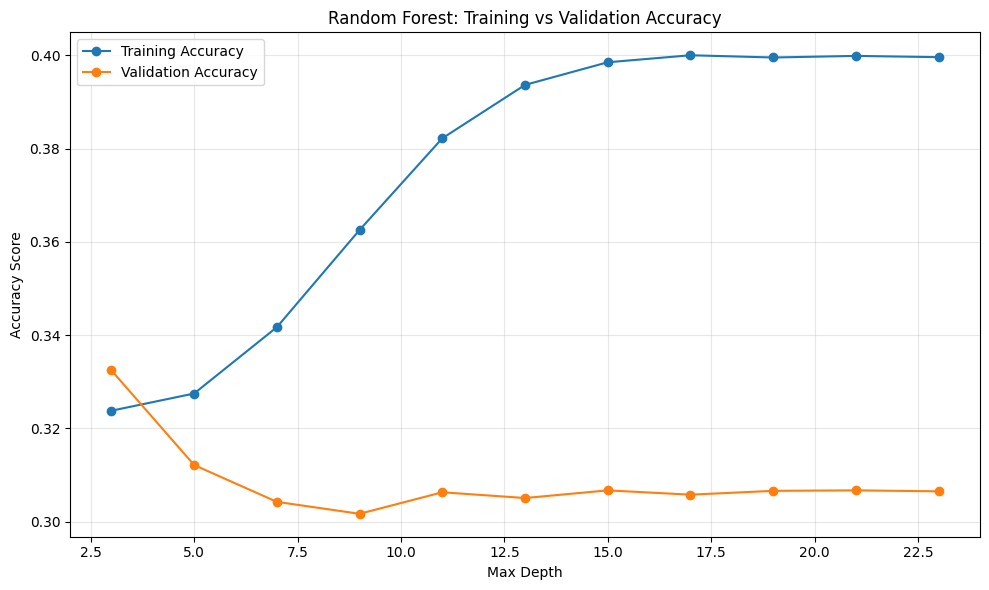

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",100
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

In [ ]:
model_preparation(X, y)

In [ ]:
model = best_model(X, y, max_depth=3, n_estimators=500)

Train score: 0.3229
Val score: 0.3331
Test score: 0.2848

Test Confusion Matrix:
[[1238  603  324  268  695]
 [ 544  454  194  270  690]
 [ 539  390  219  216  637]
 [ 130  118   91  242  652]
 [ 140  160   83  233  625]]

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.40      0.43      3128
           1       0.26      0.21      0.23      2152
           2       0.24      0.11      0.15      2001
           3       0.20      0.20      0.20      1233
           4       0.19      0.50      0.28      1241

    accuracy                           0.28      9755
   macro avg       0.27      0.28      0.26      9755
weighted avg       0.31      0.28      0.28      9755



#### Feature Importance

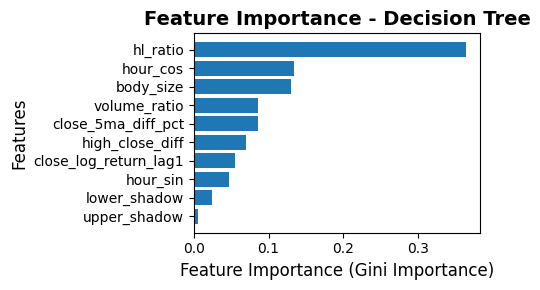


Top 10 Most Important Features:
              feature  importance
             hl_ratio    0.364800
             hour_cos    0.133892
            body_size    0.130658
         volume_ratio    0.085968
   close_5ma_diff_pct    0.085239
      high_close_diff    0.069373
close_log_return_lag1    0.054722
             hour_sin    0.046324
         lower_shadow    0.023798
         upper_shadow    0.005227

Bottom 10 Least Important Features:
              feature  importance
             hl_ratio    0.364800
             hour_cos    0.133892
            body_size    0.130658
         volume_ratio    0.085968
   close_5ma_diff_pct    0.085239
      high_close_diff    0.069373
close_log_return_lag1    0.054722
             hour_sin    0.046324
         lower_shadow    0.023798
         upper_shadow    0.005227


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance from the decision tree
feature_importance = pd.DataFrame({
    'feature': X.columns,  # Your feature names
    'importance': model.feature_importances_  # Feature importances for tree models
}).sort_values('importance', ascending=False)

# Create the chart
plt.figure(figsize=(5, 3))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance (Gini Importance)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance - Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

# Print top 10 features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Print bottom 10 features (least important)
print("\nBottom 10 Least Important Features:")
print(feature_importance.tail(10).to_string(index=False))

# Show features with zero importance (can be removed)
zero_importance = feature_importance[feature_importance['importance'] == 0]
if len(zero_importance) > 0:
    print(f"\n{len(zero_importance)} features have ZERO importance (consider removing):")
    print(zero_importance['feature'].tolist())

#### Sanity Check before walk forward

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 95% train, 5% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False
)

print(f"Train: {len(X_train)} samples")
print(f"Test: {len(X_test)} samples")

# Train model
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=3,
    min_samples_split=100,
    min_samples_leaf=50,
    max_features='sqrt',
    max_samples=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Evaluate
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Overfit Gap: {(train_acc - test_acc):.4f}")

y_pred = model.predict(X_test)
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

Train: 46334 samples
Test: 2439 samples

Train Accuracy: 0.3306
Test Accuracy: 0.3116
Overfit Gap: 0.0190

Confusion Matrix:
[[507  86  54  81 129]
 [260  83  40  81 142]
 [271  53  39  68 120]
 [ 39  16  17  57  80]
 [ 52  25  14  51  74]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.59      0.51       857
           1       0.32      0.14      0.19       606
           2       0.24      0.07      0.11       551
           3       0.17      0.27      0.21       209
           4       0.14      0.34      0.19       216

    accuracy                           0.31      2439
   macro avg       0.26      0.28      0.24      2439
weighted avg       0.32      0.31      0.29      2439



In [ ]:
# Quick test of different depths
for depth in [3, 5, 6, 8]:
    model = RandomForestClassifier(
        n_estimators=500,
        max_depth=depth,
        min_samples_split=100,
        min_samples_leaf=50,
        max_features='sqrt',
        max_samples=0.8,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    print(f"Depth={depth}: Train={train_acc:.4f}, Test={test_acc:.4f}, Gap={train_acc-test_acc:.4f}")

Depth=3: Train=0.3306, Test=0.3116, Gap=0.0190
Depth=5: Train=0.3302, Test=0.2952, Gap=0.0350
Depth=6: Train=0.3326, Test=0.2952, Gap=0.0374
Depth=8: Train=0.3479, Test=0.2981, Gap=0.0498


#### Backtesting Angel one

In [ ]:
model = RandomForestClassifier(
        n_estimators=500,
        max_depth=3,
        min_samples_split=100,
        min_samples_leaf=50,
        max_features='sqrt',
        max_samples=0.8,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",100
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [ ]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       0.43      0.63      0.51     15748
           1       0.27      0.12      0.16      9726
           2       0.26      0.06      0.10      9853
           3       0.27      0.23      0.25      7268
           4       0.21      0.45      0.29      6178

    accuracy                           0.33     48773
   macro avg       0.29      0.30      0.26     48773
weighted avg       0.31      0.33      0.29     48773



#### Backtest

In [ ]:
# Backtest with correct alignment (no look-ahead bias)

# Get predictions for test set
y_pred = model.predict(X_test)

# Get SHIFTED returns (already aligned in df)
# The shifted_log_return at time t is the return from t to t+1
test_returns = df['shifted_log_return'].iloc[-len(y_test):].values

# Remove any NaN at the end (last bar has no future return)
valid_mask = ~np.isnan(test_returns)
y_pred = y_pred[valid_mask]
test_returns = test_returns[valid_mask]

# Create positions: Long (1,3), Short (2,4), Flat (0)
positions = np.where(np.isin(y_pred, [1, 3]), 1,
                     np.where(np.isin(y_pred, [2, 4]), -1, 0))

# Strategy returns
strategy_returns = positions * test_returns

# Transaction costs (0.04% per round trip = 0.0004)
position_changes = np.abs(np.diff(positions, prepend=0))
transaction_costs = position_changes * 0.0004

# Net returns
net_returns = strategy_returns - transaction_costs

# Metrics
total_return = net_returns.sum()
mean_return = net_returns.mean()
std_return = net_returns.std()
sharpe = (mean_return / std_return) * np.sqrt(252 * 26) if std_return > 0 else 0

num_trades = position_changes.sum()
total_costs = transaction_costs.sum()

# Drawdown
cum_returns = (1 + net_returns).cumprod()
running_max = np.maximum.accumulate(cum_returns)
drawdown = (cum_returns - running_max) / running_max
max_dd = drawdown.min()

print("="*60)
print("BACKTEST RESULTS (AngelOne)")
print("="*60)
print(f"Total Return: {total_return*100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd*100:.2f}%")
print(f"Number of Trades: {num_trades:.0f}")
print(f"Total Transaction Costs: {total_costs*100:.2f}%")
print(f"Win Rate: {(net_returns > 0).sum() / len(net_returns):.2%}")
print("="*60)

BACKTEST RESULTS (AngelOne)
Total Return: -29.41%
Sharpe Ratio: -2.41
Max Drawdown: -28.78%
Number of Trades: 1351
Total Transaction Costs: 54.04%
Win Rate: 25.38%


In [ ]:
# Backtest: ONLY Class 3 & 4 (no Classes 1 & 2)
y_pred = model.predict(X_test)
test_returns = df['shifted_log_return'].iloc[-len(y_test):].values

valid_mask = ~np.isnan(test_returns)
y_pred = y_pred[valid_mask]
test_returns = test_returns[valid_mask]

# CHANGE: Only trade Class 3 & 4
positions = np.where(y_pred == 3, 1,
                     np.where(y_pred == 4, -1, 0))

strategy_returns = positions * test_returns
position_changes = np.abs(np.diff(positions, prepend=0))
transaction_costs = position_changes * 0.0004
net_returns = strategy_returns - transaction_costs

total_return = net_returns.sum()
sharpe = (net_returns.mean() / net_returns.std()) * np.sqrt(252 * 26) if net_returns.std() > 0 else 0
num_trades = position_changes.sum()

print("="*60)
print("BACKTEST: ONLY CLASS 3 & 4")
print("="*60)
print(f"Total Return: {total_return*100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Num Trades: {num_trades:.0f}")
print(f"Transaction Costs: {transaction_costs.sum()*100:.2f}%")
print(f"Win Rate: {(net_returns > 0).sum() / len(net_returns):.2%}")
print("="*60)

BACKTEST: ONLY CLASS 3 & 4
Total Return: -12.89%
Sharpe Ratio: -1.17
Num Trades: 883
Transaction Costs: 35.32%
Win Rate: 17.10%


In [ ]:
# Get prediction probabilities
y_pred_proba = model.predict_proba(X_test)
test_returns = df['shifted_log_return'].iloc[-len(y_test):].values

# Remove NaN
valid_mask = ~np.isnan(test_returns)
y_pred_proba = y_pred_proba[valid_mask]
test_returns = test_returns[valid_mask]

threshold = 0.24

# Only trade when model is >70% confident
# Class 3 = index 3, Class 4 = index 4
positions = np.where(y_pred_proba[:, 3] > threshold, 1,      # Long if >threshold% conf Class 3
                     np.where(y_pred_proba[:, 4] > threshold, -1, 0))  # Short if >threshold% conf Class 4

# Strategy returns
strategy_returns = positions * test_returns

# Transaction costs
position_changes = np.abs(np.diff(positions, prepend=0))
transaction_costs = position_changes * 0.0004

# Net returns
net_returns = strategy_returns - transaction_costs

# Metrics
total_return = net_returns.sum()
sharpe = (net_returns.mean() / net_returns.std()) * np.sqrt(252 * 26) if net_returns.std() > 0 else 0
num_trades = position_changes.sum()

# Win rate (only on traded bars)
traded_mask = positions != 0
if traded_mask.sum() > 0:
    win_rate = (net_returns[traded_mask] > 0).sum() / traded_mask.sum()
else:
    win_rate = 0

print("="*60)
print(f"BACKTEST: >{threshold}% CONFIDENCE ONLY")
print("="*60)
print(f"Total Return: {total_return*100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Num Trades: {num_trades:.0f}")
print(f"Bars Traded: {traded_mask.sum()}")
print(f"Transaction Costs: {transaction_costs.sum()*100:.2f}%")
print(f"Win Rate (on trades): {win_rate:.2%}")
print(f"Avg Return per Trade: {total_return/max(num_trades/2, 1)*100:.3f}%")
print("="*60)

# Check: How often is model >70% confident?
print(f"\nConfidence Analysis:")
print(f"Class 3 (Big Up) >{threshold}% confident: {(y_pred_proba[:, 3] > threshold).sum()} times")
print(f"Class 4 (Big Down) >{threshold}% confident: {(y_pred_proba[:, 4] > threshold).sum()} times")
print(f"Total high-confidence predictions: {((y_pred_proba[:, 3] > threshold) | (y_pred_proba[:, 4] > 0.70)).sum()}")

BACKTEST: >0.24% CONFIDENCE ONLY
Total Return: 21.60%
Sharpe Ratio: 2.14
Num Trades: 550
Bars Traded: 634
Transaction Costs: 22.00%
Win Rate (on trades): 53.31%
Avg Return per Trade: 0.079%

Confidence Analysis:
Class 3 (Big Up) >0.24% confident: 510 times
Class 4 (Big Down) >0.24% confident: 480 times
Total high-confidence predictions: 510


In [ ]:
# Test multiple thresholds
thresholds = np.arange(0.20, 0.40, 0.01)
results = []

for thresh in thresholds:
    positions = np.where(y_pred_proba[:, 3] > thresh, 1,
                         np.where(y_pred_proba[:, 4] > thresh, -1, 0))
    
    strategy_returns = positions * test_returns
    position_changes = np.abs(np.diff(positions, prepend=0))
    transaction_costs = position_changes * 0.0004
    net_returns = strategy_returns - transaction_costs
    
    num_trades = position_changes.sum()
    sharpe = (net_returns.mean() / net_returns.std()) * np.sqrt(252 * 26) if net_returns.std() > 0 else 0
    
    traded_mask = positions != 0
    win_rate = (net_returns[traded_mask] > 0).sum() / traded_mask.sum() if traded_mask.sum() > 0 else 0
    
    results.append({
        'threshold': thresh,
        'sharpe': sharpe,
        'num_trades': num_trades,
        'win_rate': win_rate,
        'total_return': net_returns.sum()
    })

# Display
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)
print(f"\nBest Sharpe at threshold: {results_df.loc[results_df['sharpe'].idxmax(), 'threshold']}")

    threshold    sharpe  num_trades  win_rate  total_return
0        0.20  0.859287         761  0.507056      0.100069
1        0.21  0.225909         707  0.502179      0.025044
2        0.22  0.501170         665  0.494048      0.054875
3        0.23  1.444585         608  0.500680      0.152443
4        0.24  2.135587         550  0.533123      0.215967
5        0.25  1.957363         496  0.531802      0.195004
6        0.26  0.629856         446  0.532673      0.060563
7        0.27  1.638582         410  0.553047      0.154495
8        0.28  0.962401         410  0.521628      0.089326
9        0.29  0.953711         386  0.554896      0.083971
10       0.30  1.128054         360  0.562249      0.085557
11       0.31 -0.374807         276  0.535032     -0.018468
12       0.32 -1.413866         212  0.513043     -0.060164
13       0.33 -0.588898         144  0.536585     -0.020650
14       0.34 -2.701960         110  0.491525     -0.076545
15       0.35 -1.466458          78  0.5